In [1]:
import pandas as pd
import numpy as np
#from nphc.main import NPHC
#from nphc.utils.cumulants import Cumulants
from scipy.linalg import sqrtm, inv, eigh
from numpy import sqrt
import matplotlib
matplotlib.use('Agg')

import mlpp.hawkesnoparam as hnp

import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

In [4]:
# data for Eurex futures are in this store
store = pd.HDFStore('/data/data/QH/L1.h5', 'r')
# to get one day
df = store.get('xFGBL/20140922')

In [93]:
def PriceUp(df):
    return (df.PriceMove > 0).values

def PriceDown(df):
    return (df.PriceMove < 0).values

def MarketOrdersAsk(df):
    return (df.PriceMove == 0).values * (df.AskQtyAfter > df.AskQtyBefore).values

def MarketOrdersBid(df):
    return (df.PriceMove == 0).values * (df.BidQtyAfter > df.BidQtyBefore).values    

def GetOrderBookEvents(df):
    """ Given df representing one day of data, returns list of array representing
        order book events for mid-price moves (ask/bid), number of market orders 
        (ask/bid), number of limit order (ask/bid), number of cancel orders (ask/bid)"""
    
    out = []
    out += [np.copy(df.loc[PriceUp(df), "Time"].values)]
    out += [np.copy(df.loc[PriceDown(df), "Time"].values)]
    out += [np.copy(df.loc[MarketOrdersAsk(df), "Time"].values)]
    out += [np.copy(df.loc[MarketOrdersBid(df), "Time"].values)]
    return out

In [94]:
def GetComponents(df, vol_bins):
    """ Given df representing one day of data, returns list of array representing 
        trades time for each volume component"""
    
    mask = lambda x, y: (df.OrderType==0).values * (np.abs(df.Volume.values)>x) * (np.abs(df.Volume.values)<=y)
    out = []
    for ii in range(len(vol_bins)-1): 
        out += [np.copy(df.loc[mask(vol_bins[ii], vol_bins[ii+1]), 'Time'].values)]
    return out

## Data store

In [95]:
# data for Eurex futures are in this store
store = pd.HDFStore('/data/data/QH/L1.h5', 'r')

# each dataframe in the store represents one day
# name of the assets are 'xFDAX' and 'xFGBL'
# to access an asset on a particular day do
# store.get['_ast_name/YYYYmmdd']

In [96]:
# to get one day
df = store.get('xFGBL/20140922')

## Non-parametric hawkes Bacry

In [97]:
# in the paper we examined trades and considered multilpe components based on volume
# volume buckets:
bins4D = (0,1,3,10, np.inf)
bins6D = (0, 2, 3, 7, 20, np.inf)

### Estim conditional law

In [99]:
# to do non par est we need to create estim object

# estimation parameters 
est_par = dict(hMax=2000, # max lag
               hMin=5e-4, # after hMin buckets are log-spaced
               hDelta=0.01, # regulates number of bins
               claw_method="log", n_threads=-1)

est = hnp.Estim(**est_par)

# do estimation using one month of data

asset = 'xFGBL'
days = pd.bdate_range(start='20140101', end='20140110')
big_data = []

# add realization and estimate claw
# 4D case
for d in days:
    
    try:
        df = store.get('%s/%s' %(asset, d.strftime('%Y%m%d')))
    except KeyError:
        continue
        
    #data = GetComponents(df, bins4D)
    data = GetOrderBookEvents(df)
    big_data.append(data)
    
    est.add_realization(data)

[]

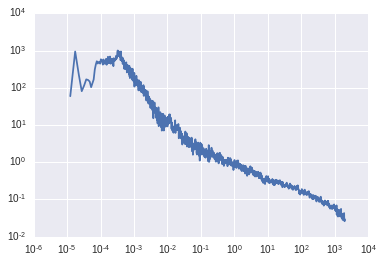

In [100]:
# estimate conditional law values are in 
# est.claw (single index) or est.claw1[i][j]

# the corresponding x-values are in 
# est.claw_X

plt.plot(est.claw_X, est.claw1[0][1])
plt.loglog()

### Compute kernels

In [101]:
# to compute the kernel do 
est.compute(n_quad=80, xmax=1, method='log', xmin=5e-4)

/data/users/achab/mlpp/mlpp/hawkesnoparam/estim.py:662: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.phi[i].append(self._phi_ijl[index]*self._mark_probabilities[j][0])


[]

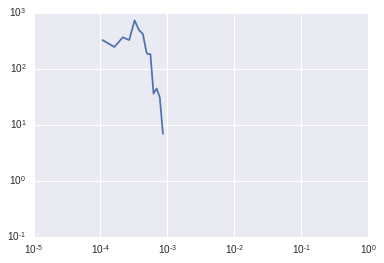

In [102]:
# to access the kernels
# phi_x, phi_y = est.phi[i][j] 
phi_x, phi_y = est.phi[0][1]

plt.plot(phi_x, phi_y)
plt.loglog()

### Norms

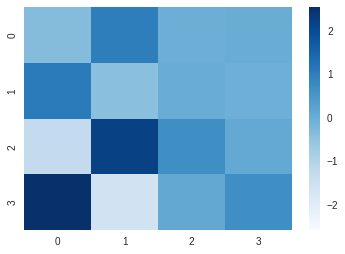

In [103]:
# norms are in 
# est.norm
sns.heatmap(est.norm, cmap='Blues')

# Covariance density has fat tail

In [104]:
len(big_data)

7

In [105]:
from nphc.main import NPHC, starting_point
import nphc.utils.cumulants as cu

#cumul = cu.Cumulants(big_data)
list_cumul = [ cu.Cumulants(daily_data) for daily_data in big_data ]

In [106]:
cumul_ = list_cumul[0]
process = cumul_.N
T = cumul_.time
cumul_.set_L()

In [124]:
i = 0
j = 1

from nphc.utils.cumulants import A_ij
from joblib import Parallel, delayed
H_range = np.logspace(-3,3,300)
Z = Parallel(-1)(delayed(A_ij)(process[i], process[j], -H, H, T, cumul_.L[j]) for H in H_range)
Z = np.array(Z)

In [125]:
X = H_range[:-1]
Y = np.diff(Z)/np.diff(H_range)

In [126]:
from scipy.stats import linregress
cond = X > 5.
x = X[cond]
y = Y[cond]
slope, intercept = linregress(np.log(x), np.log(y))[:2]

In [128]:
print("slope = {}".format(slope))

slope = -0.36620799464426484


In [129]:
from math import exp
line = exp(intercept) * X**slope

[]

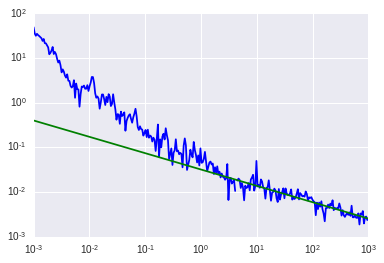

In [131]:
#plt.plot(X, Y, 'b')
plt.plot(X, Y, 'b', X, line, 'g')
plt.loglog()

# Retrieve the norm via NPHC

In [132]:
for cumul in list_cumul:
    cumul.set_all(H=1.,weight='gaussian',sigma=.2)

L is computed
C is computed


Process ForkPoolWorker-331:
Process ForkPoolWorker-321:
Process ForkPoolWorker-328:
Process ForkPoolWorker-330:
Process ForkPoolWorker-298:
Process ForkPoolWorker-315:
Process ForkPoolWorker-320:
Process ForkPoolWorker-333:
Process ForkPoolWorker-304:
Process ForkPoolWorker-327:
Process ForkPoolWorker-332:
Process ForkPoolWorker-336:
Process ForkPoolWorker-334:
Process ForkPoolWorker-307:
Process ForkPoolWorker-329:
Process ForkPoolWorker-326:
Process ForkPoolWorker-308:
Process ForkPoolWorker-309:
Process ForkPoolWorker-323:
Process ForkPoolWorker-324:
Process ForkPoolWorker-325:
Process ForkPoolWorker-303:
Process ForkPoolWorker-290:
Process ForkPoolWorker-301:
Process ForkPoolWorker-313:
Process ForkPoolWorker-293:
Process ForkPoolWorker-302:
Process ForkPoolWorker-299:
Process ForkPoolWorker-311:
Process ForkPoolWorker-294:
Process ForkPoolWorker-286:
Process ForkPoolWorker-310:
Process ForkPoolWorker-285:
Process ForkPoolWorker-284:
Process ForkPoolWorker-312:
Process ForkPoolWork

KeyboardInterrupt: 

  File "/home/achab/.conda/envs/env-mlpp/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/achab/.conda/envs/env-mlpp/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/achab/.conda/envs/env-mlpp/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/achab/.conda/envs/env-mlpp/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/achab/.conda/envs/env-mlpp/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/achab/.conda/envs/env-mlpp/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/achab/.conda/envs/env-mlpp/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/achab/.conda/envs/env-mlpp/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/achab/.conda/envs/env-mlpp/lib/python3.5/m

In [ ]:
R0 = np.mean([starting_point(cumul) for cumul in list_cumul], axis=0)
#R0 = starting_point(list_cumulants)

In [ ]:
learning_rate=1e0
training_epochs=1001
display_step=100

In [ ]:
C_mean = np.mean([cumul.C for cumul in list_cumul], axis=0)
K_c_mean = np.mean([cumul.K_c for cumul in list_cumul], axis=0)

In [ ]:
from scipy.linalg import norm
alpha = norm(K_c_mean)**2 / (norm(K_c_mean)**2 + norm(C_mean)**2)

In [ ]:
#R0 = np.ones((d,d)) + np.random.rand(d,d)

In [ ]:
R = NPHC(list_cumul,R0,alpha=0.,training_epochs=training_epochs,\
         display_step=display_step,learning_rate=learning_rate,optimizer='adagrad')

In [ ]:
d = list_cumul[0].dim
from scipy.linalg import inv
G = np.eye(d) - inv(R)
G0 = np.eye(d) - inv(R0)

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axs = plt.subplots(1, 2, sharey=True,figsize=(15,5))
labels = ['Wiener-Hopf', 'NPHC']

for ax, data, label in zip(axs, [np.array(est.norm), G], labels):
    
    
    colors = [plt.cm.viridis, plt.cm.magma, plt.cm.inferno, plt.cm.Blues, plt.cm.jet]
    color = colors[3]
    heatmap = ax.pcolor(data[::-1], cmap=color, alpha=.8) #, vmin=-0.1,vmax=.8)
        
    ax.set_xlabel(label,fontsize=30)
    plt.setp(ax.get_xticklabels(),visible=False)
    plt.setp(ax.get_yticklabels(),visible=False)
    
    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.82, 0.12, 0.02, .78])
    fig.colorbar(heatmap, cax=cax)